# Image Classification German Traffic Signals

## Load all libraries

In [61]:
## Libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import visualkeras

## Extract images from the zipfile

In [62]:
import zipfile
zip_ref = zipfile.ZipFile('archive.zip', 'r')
zip_ref.extractall('../Project/archive_new')
zip_ref.close()

## Read in the training dataset images and convert them to 30\*30 resolution

In [63]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height * width * channels

for i in range(classes) :
    path = "../Project/archive_new/Train/{0}/".format(i)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

## Splitting images into training and validation set

In [65]:
#Splitting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#Using one hote encoding for the train and validation labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## Read in the test dataset images and convert them to 30\*30 resolution

In [66]:
#Predicting with the test data
y_test=pd.read_csv("../Project/archive_new/Test.csv")
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]

for f in labels:
    image=cv2.imread('../Project/archive_new/Test/'+f.replace('Test/', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 

In [67]:
X_train.shape,y_train.shape, X_val.shape,y_val.shape, X_test.shape,y_test.shape

((31368, 30, 30, 3),
 (31368, 43),
 (7841, 30, 30, 3),
 (7841, 43),
 (12630, 30, 30, 3),
 (12630,))

## Dictionary of 43 class labels

In [68]:
class_desc = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Define a function to fit the training set to the model

In [25]:
def model_fitting(model, X_train, y_train, X_val, y_val):
    # Using ten epochs for the training and saving the accuracy for each epoch
    epochs = 15
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
    validation_data=(X_val, y_val))
    
    return history

## Function to display training and validation accuracy versus epochs

In [26]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(0)
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    return

def plot_validation(history):    
    plt.figure(1)
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    return

## Function to predict the image class label 

In [27]:
def predict_class(model, X_test):
    pred_x = model.predict(X_test)
    classes_x=np.argmax(pred_x,axis=1)
    
    return classes_x

## Function to return accuracy score of the model

In [28]:
#Accuracy with the test data
from sklearn.metrics import accuracy_score

def accuracy(y_test, classes_x):
    return accuracy_score(y_test, classes_x)

## Function to plot the confusion matrix

In [29]:
from sklearn import metrics

def confusion_matrix_plot(y_test, classes_x):
    cnf_matrix_test = metrics.confusion_matrix(y_test, classes_x)

    ticks = [str(i) for i in range(classes)]

    plt.figure(figsize=(20,20))
    plt.imshow(cnf_matrix_test, interpolation='nearest', cmap='Pastel1')
    plt.title('Confusion matrix - Test Set', size = 15)
    tick_marks = np.arange(43)
    plt.xticks(tick_marks, ticks, rotation=45, size = 10)
    plt.yticks(tick_marks, ticks, size = 10)
    plt.tight_layout()
    plt.ylabel('Actual label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    width, height = cnf_matrix_test.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cnf_matrix_test[x][y]), xy=(y, x), 
            horizontalalignment='center',
            verticalalignment='center')
    
    return cnf_matrix_test

## Function to display common patterns in image misclassification

In [30]:
def misclassified_img(cnf_matrix_test, X_test, y_test):

    cnf_matrix_new = cnf_matrix_test
    np.fill_diagonal(cnf_matrix_new, 0)
    cnf_matrix_new = pd.DataFrame(cnf_matrix_new)

    index = []
    cols = []
    val = []

    for i in range(classes):
        lst = cnf_matrix_new.index[cnf_matrix_new[i]>10].to_list()
        if len(lst)>0:
            index.append(lst)
            cols.append([i]*len(lst))
            
    t = []
    [t.extend(x) for x in index]
    index = t
    
    t = []
    [t.extend(x) for x in cols]
    cols = t

    return index,cols

def plot_misclassified_img(index, cols, X_test, y_test, grid_x, grid_y):
    i = 0
    fig, ax = plt.subplots(grid_x, grid_y, sharex= True, sharey=False)
    fig.set_size_inches(30, 15,  forward=True)

    for idx, ax_i in enumerate(ax.flatten()):
        actual_class = index[idx]
        predicted_class = cols[idx]
        mask_actual_2 = (y_test == actual_class)
        mask_wrong_predictions = (classes_x == predicted_class)

        final_mask = mask_wrong_predictions & mask_actual_2


        ax_i.imshow(X_test[final_mask][0])
        ax_i.set_title(f'Actual: {class_desc[y_test[final_mask][0]]};\nPredicted: {class_desc[classes_x[final_mask][0]]}\n#Misclassifications: {final_mask.sum()}',fontsize=16)
        ax_i.axis('off')

    plt.show()

### Model 1: CNN 3 layers

In [20]:
#Definition of the DNN model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model_1 = Sequential()
model_1.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model_1.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.25))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(rate=0.5))
model_1.add(Dense(43, activation='softmax'))

#Compilation of the model
model_1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

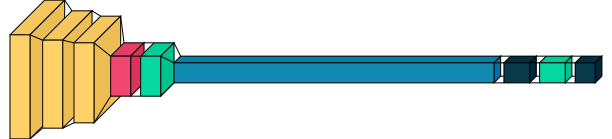

In [43]:
#change the model number to the the best performing one
visualkeras.layered_view(model_1)

In [22]:
history_1 = model_fitting(model_1, X_train, y_train, X_val, y_val)

Epoch 1/15
981/981 [==============================] - 62s 63ms/step - loss: 0.7046 - accuracy: 0.8038 - val_loss: 0.0907 - val_accuracy: 0.9788
Epoch 2/15
981/981 [==============================] - 65s 66ms/step - loss: 0.1471 - accuracy: 0.9569 - val_loss: 0.0448 - val_accuracy: 0.9884
Epoch 3/15
981/981 [==============================] - 68s 69ms/step - loss: 0.0916 - accuracy: 0.9729 - val_loss: 0.0426 - val_accuracy: 0.9901
Epoch 4/15
981/981 [==============================] - 66s 67ms/step - loss: 0.0706 - accuracy: 0.9779 - val_loss: 0.0318 - val_accuracy: 0.9927
Epoch 5/15
981/981 [==============================] - 66s 67ms/step - loss: 0.0571 - accuracy: 0.9824 - val_loss: 0.0398 - val_accuracy: 0.9909
Epoch 6/15
981/981 [==============================] - 69s 70ms/step - loss: 0.0491 - accuracy: 0.9856 - val_loss: 0.0304 - val_accuracy: 0.9941
Epoch 7/15
981/981 [==============================] - 70s 72ms/step - loss: 0.0453 - accuracy: 0.9870 - val_loss: 0.0262 - val_accuracy:

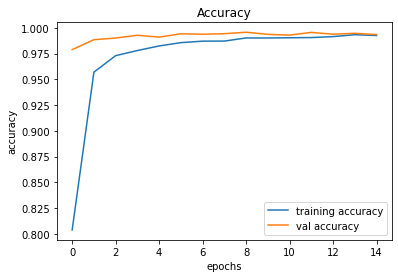

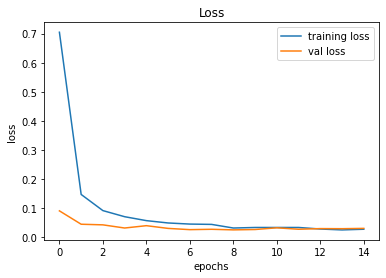

In [23]:
plot_accuracy(history_1)
plot_validation(history_1)

In [26]:
classes_x = predict_class(model_1, X_test)
model_1_accuracy = accuracy(y_test, classes_x)
print(model_1_accuracy)

0.9569279493269992


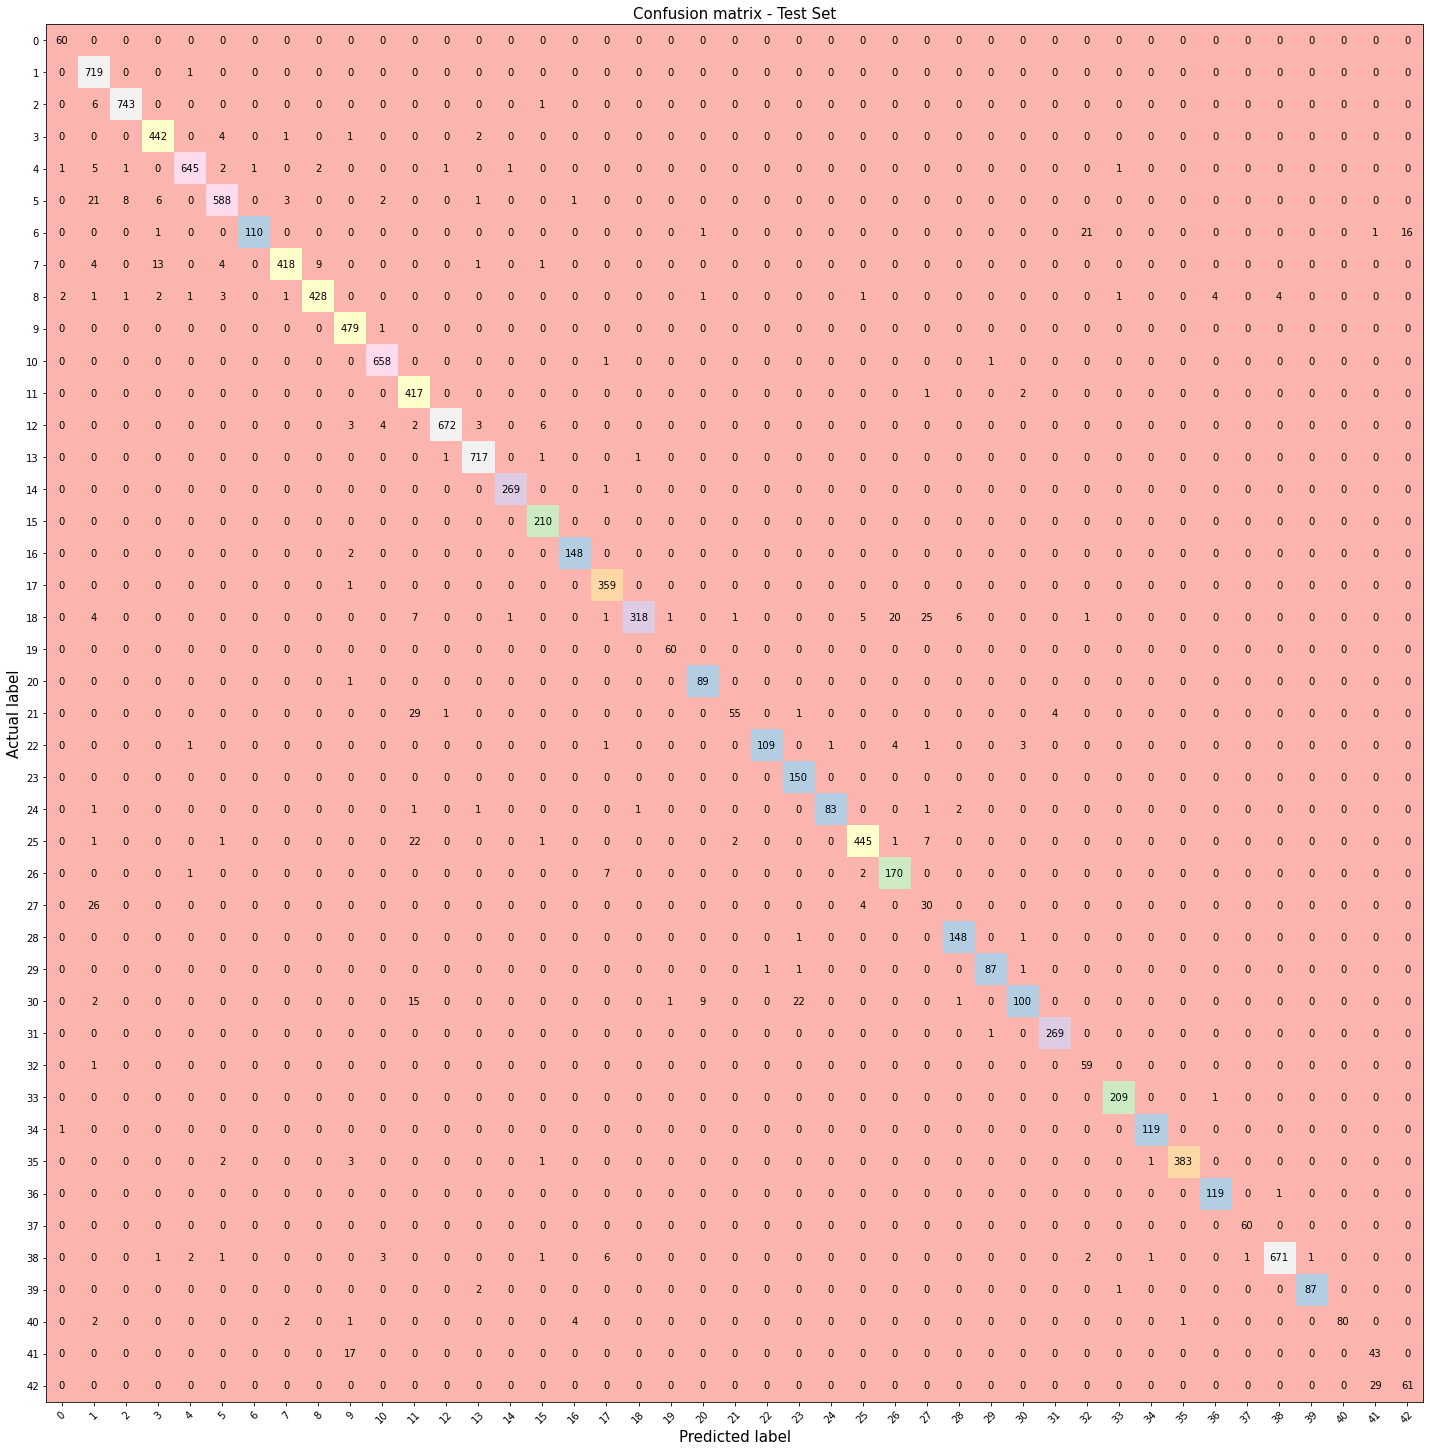

In [27]:
cnf_matrix_test = confusion_matrix_plot(y_test, classes_x)

In [28]:
index,cols = misclassified_img(cnf_matrix_test, X_test, y_test)
print(index,cols,len(index))

[5, 27, 7, 41, 21, 25, 30, 30, 18, 18, 6, 42, 6] [1, 1, 3, 9, 11, 11, 11, 23, 26, 27, 32, 41, 42] 13


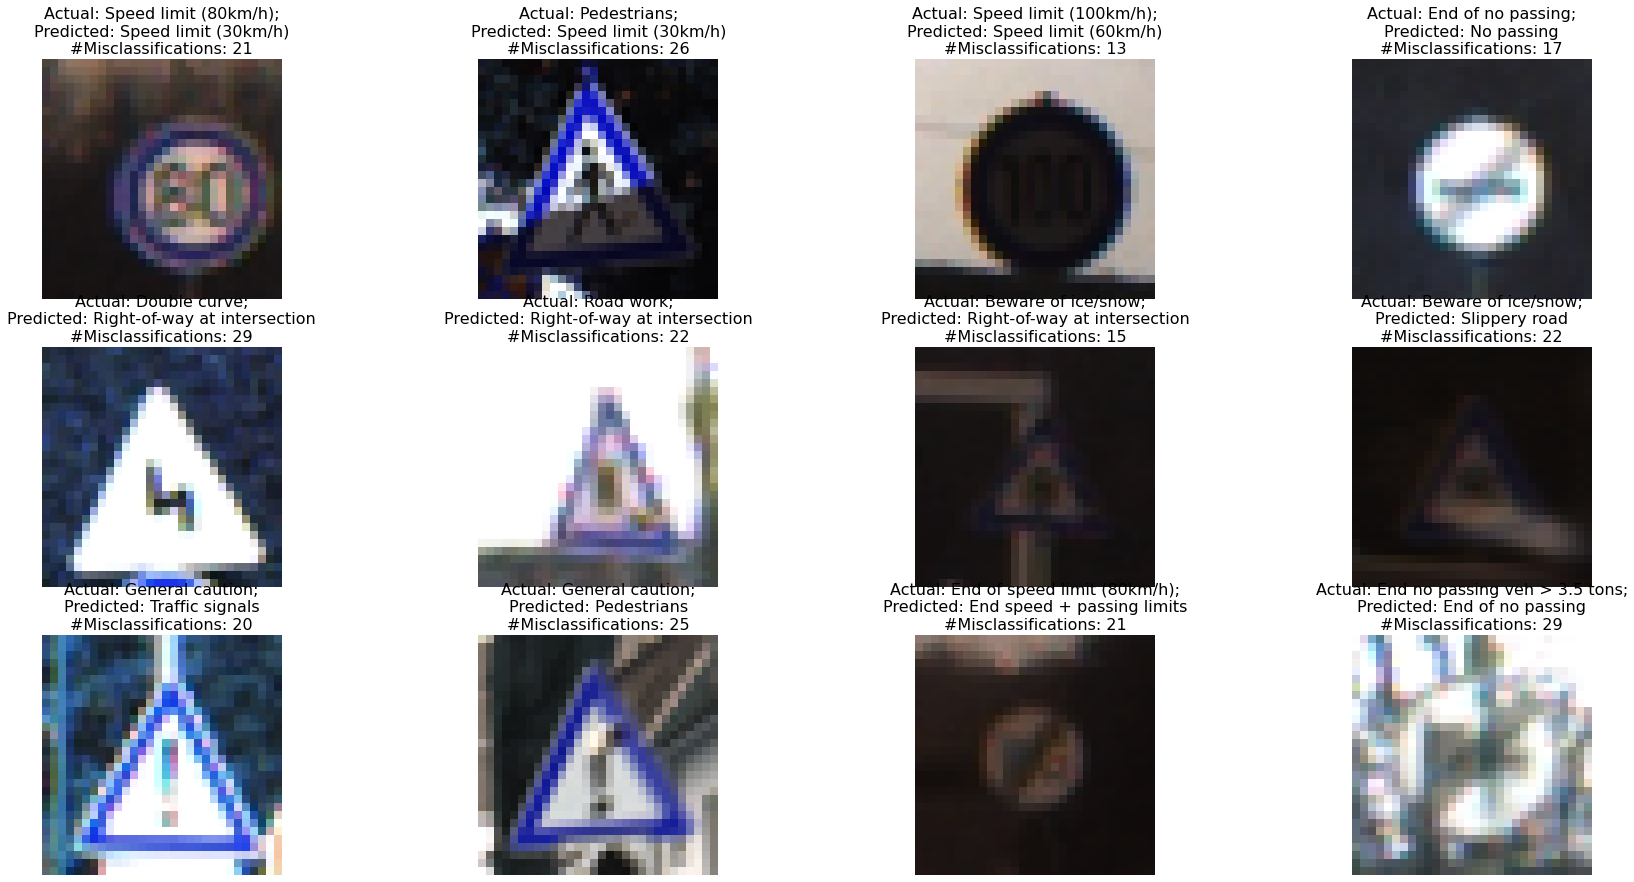

In [30]:
plot_misclassified_img(index, cols, X_test, y_test, 3, 4)

## Model 2 - CNN 4 layers

In [31]:
model_2 = Sequential()
model_2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model_2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.25))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.25))
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(rate=0.5))
model_2.add(Dense(43, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

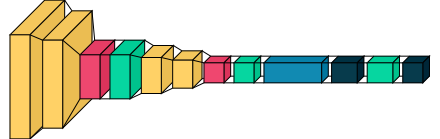

In [44]:
#change the model number to the the best performing one
visualkeras.layered_view(model_2)

In [32]:
history_2 = model_fitting(model_2, X_train, y_train, X_val, y_val)

Epoch 1/15
981/981 [==============================] - 59s 60ms/step - loss: 1.2780 - accuracy: 0.6415 - val_loss: 0.1675 - val_accuracy: 0.9514
Epoch 2/15
981/981 [==============================] - 61s 62ms/step - loss: 0.2418 - accuracy: 0.9263 - val_loss: 0.0679 - val_accuracy: 0.9825
Epoch 3/15
981/981 [==============================] - 66s 67ms/step - loss: 0.1550 - accuracy: 0.9525 - val_loss: 0.0452 - val_accuracy: 0.9872
Epoch 4/15
981/981 [==============================] - 59s 60ms/step - loss: 0.1235 - accuracy: 0.9643 - val_loss: 0.0435 - val_accuracy: 0.9883
Epoch 5/15
981/981 [==============================] - 63s 64ms/step - loss: 0.1018 - accuracy: 0.9699 - val_loss: 0.0421 - val_accuracy: 0.9888
Epoch 6/15
981/981 [==============================] - 63s 64ms/step - loss: 0.0915 - accuracy: 0.9716 - val_loss: 0.0422 - val_accuracy: 0.9886
Epoch 7/15
981/981 [==============================] - 63s 65ms/step - loss: 0.0798 - accuracy: 0.9764 - val_loss: 0.0286 - val_accuracy:

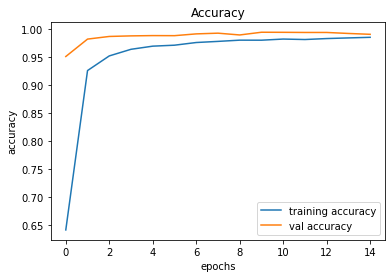

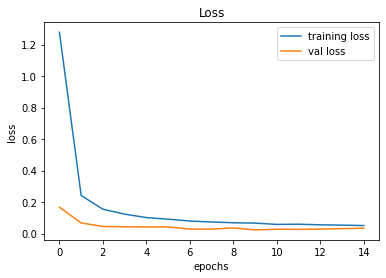

In [33]:
plot_accuracy(history_2)
plot_validation(history_2)

In [34]:
classes_x = predict_class(model_2, X_test)
model_2_accuracy = accuracy(y_test, classes_x)
print(model_2_accuracy)

0.9677751385589866


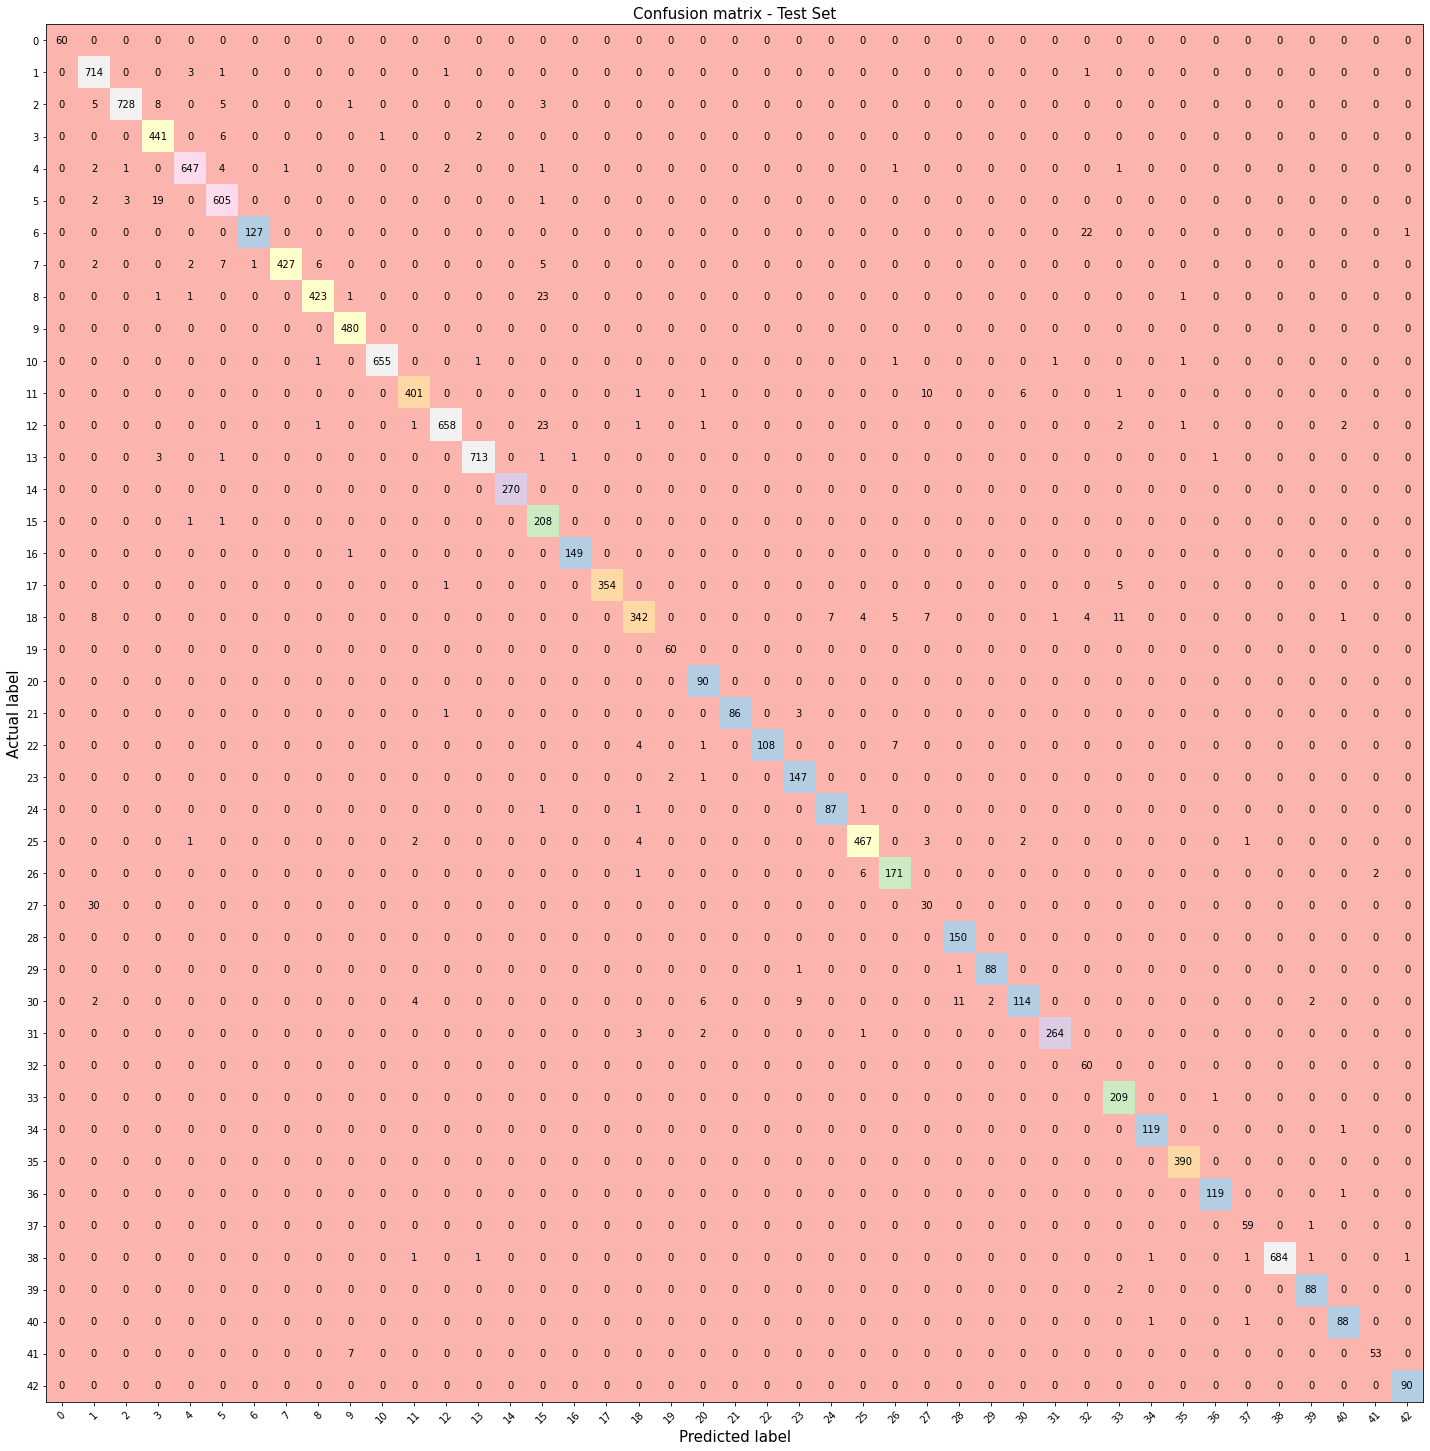

In [35]:
cnf_matrix_test = confusion_matrix_plot(y_test, classes_x)

In [36]:
index, cols = misclassified_img(cnf_matrix_test, X_test, y_test)
print(index, cols, len(index))

[27, 5, 8, 12, 30, 6, 18] [1, 3, 15, 15, 28, 32, 33] 7


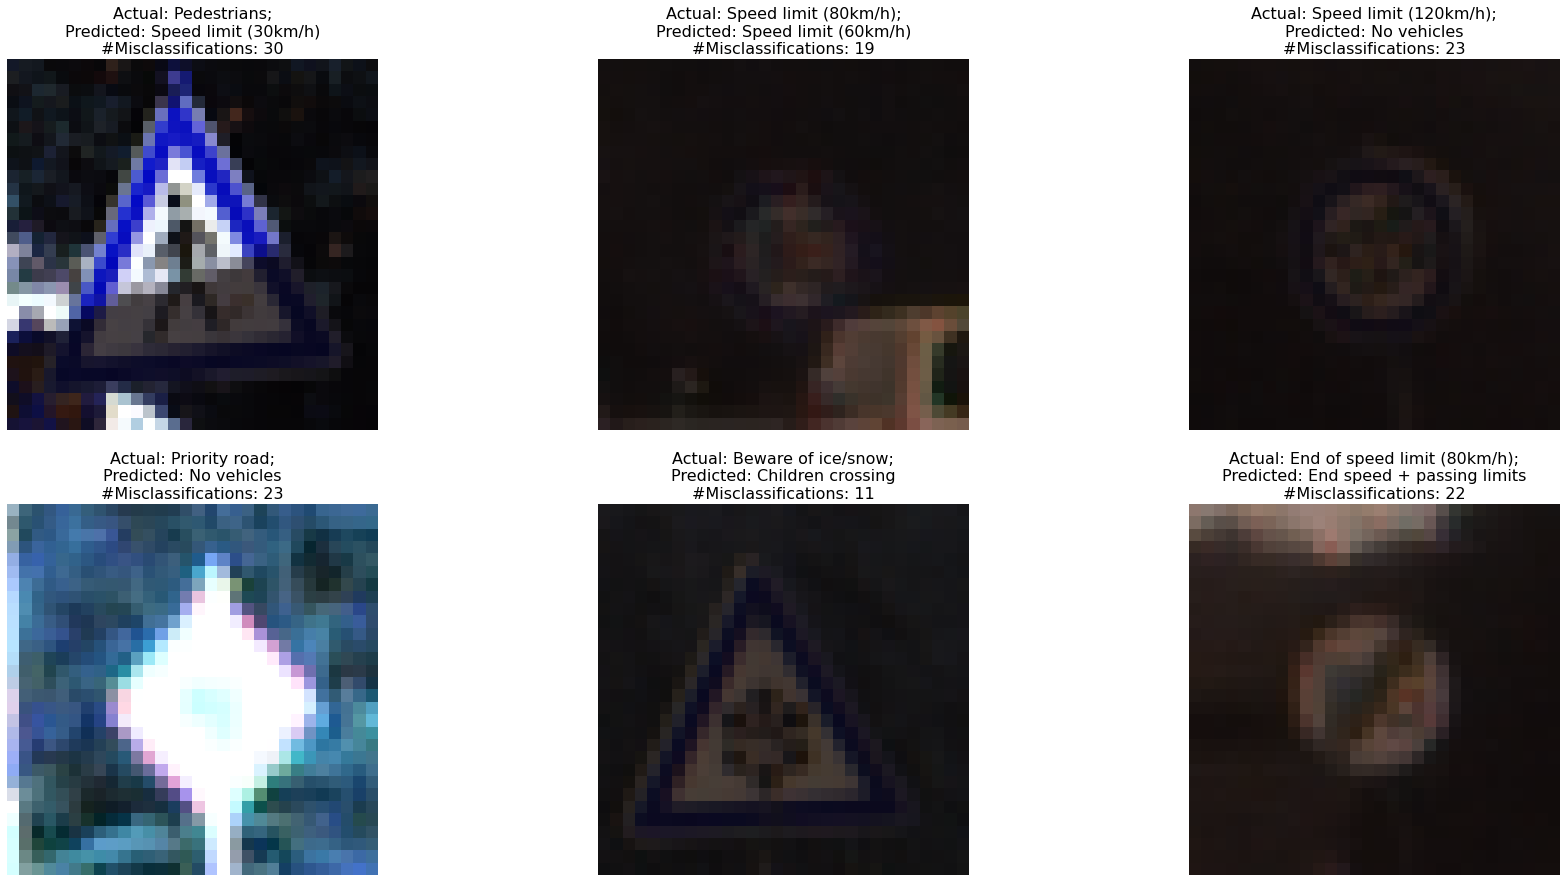

In [38]:
plot_misclassified_img(index, cols, X_test, y_test, 2, 3)

## Model 3 - CNN 2 layers

In [216]:
model_3 = Sequential()
model_3.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model_3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_3.add(MaxPool2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.25))
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(43, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

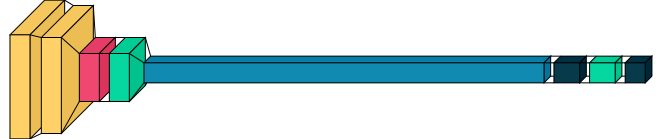

In [217]:
#change the model number to the the best performing one
visualkeras.layered_view(model_3)

In [218]:
history_3 = model_fitting(model_3, X_train, y_train, X_val, y_val)

Epoch 1/15
981/981 [==============================] - 91s 92ms/step - loss: 0.9629 - accuracy: 0.7330 - val_loss: 0.1345 - val_accuracy: 0.9709
Epoch 2/15
981/981 [==============================] - 88s 90ms/step - loss: 0.1977 - accuracy: 0.9411 - val_loss: 0.0700 - val_accuracy: 0.9844
Epoch 3/15
981/981 [==============================] - 79s 80ms/step - loss: 0.1238 - accuracy: 0.9637 - val_loss: 0.0460 - val_accuracy: 0.9899
Epoch 4/15
981/981 [==============================] - 80s 81ms/step - loss: 0.0911 - accuracy: 0.9728 - val_loss: 0.0359 - val_accuracy: 0.9925
Epoch 5/15
981/981 [==============================] - 87s 89ms/step - loss: 0.0767 - accuracy: 0.9766 - val_loss: 0.0359 - val_accuracy: 0.9912
Epoch 6/15
981/981 [==============================] - 87s 88ms/step - loss: 0.0578 - accuracy: 0.9824 - val_loss: 0.0304 - val_accuracy: 0.9926
Epoch 7/15
981/981 [==============================] - 88s 90ms/step - loss: 0.0491 - accuracy: 0.9844 - val_loss: 0.0324 - val_accuracy:

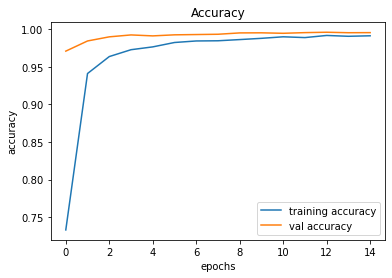

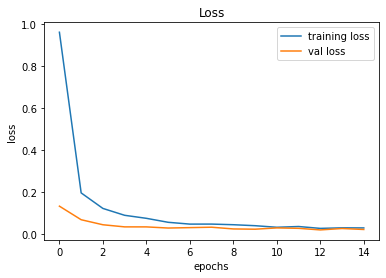

In [219]:
plot_accuracy(history_3)
plot_validation(history_3)

In [220]:
classes_x = predict_class(model_3, X_test)
model_3_accuracy = accuracy(y_test, classes_x)
print(model_3_accuracy)

0.9689627870150436


In [ ]:
print(classification_report(y_test, classes_x))

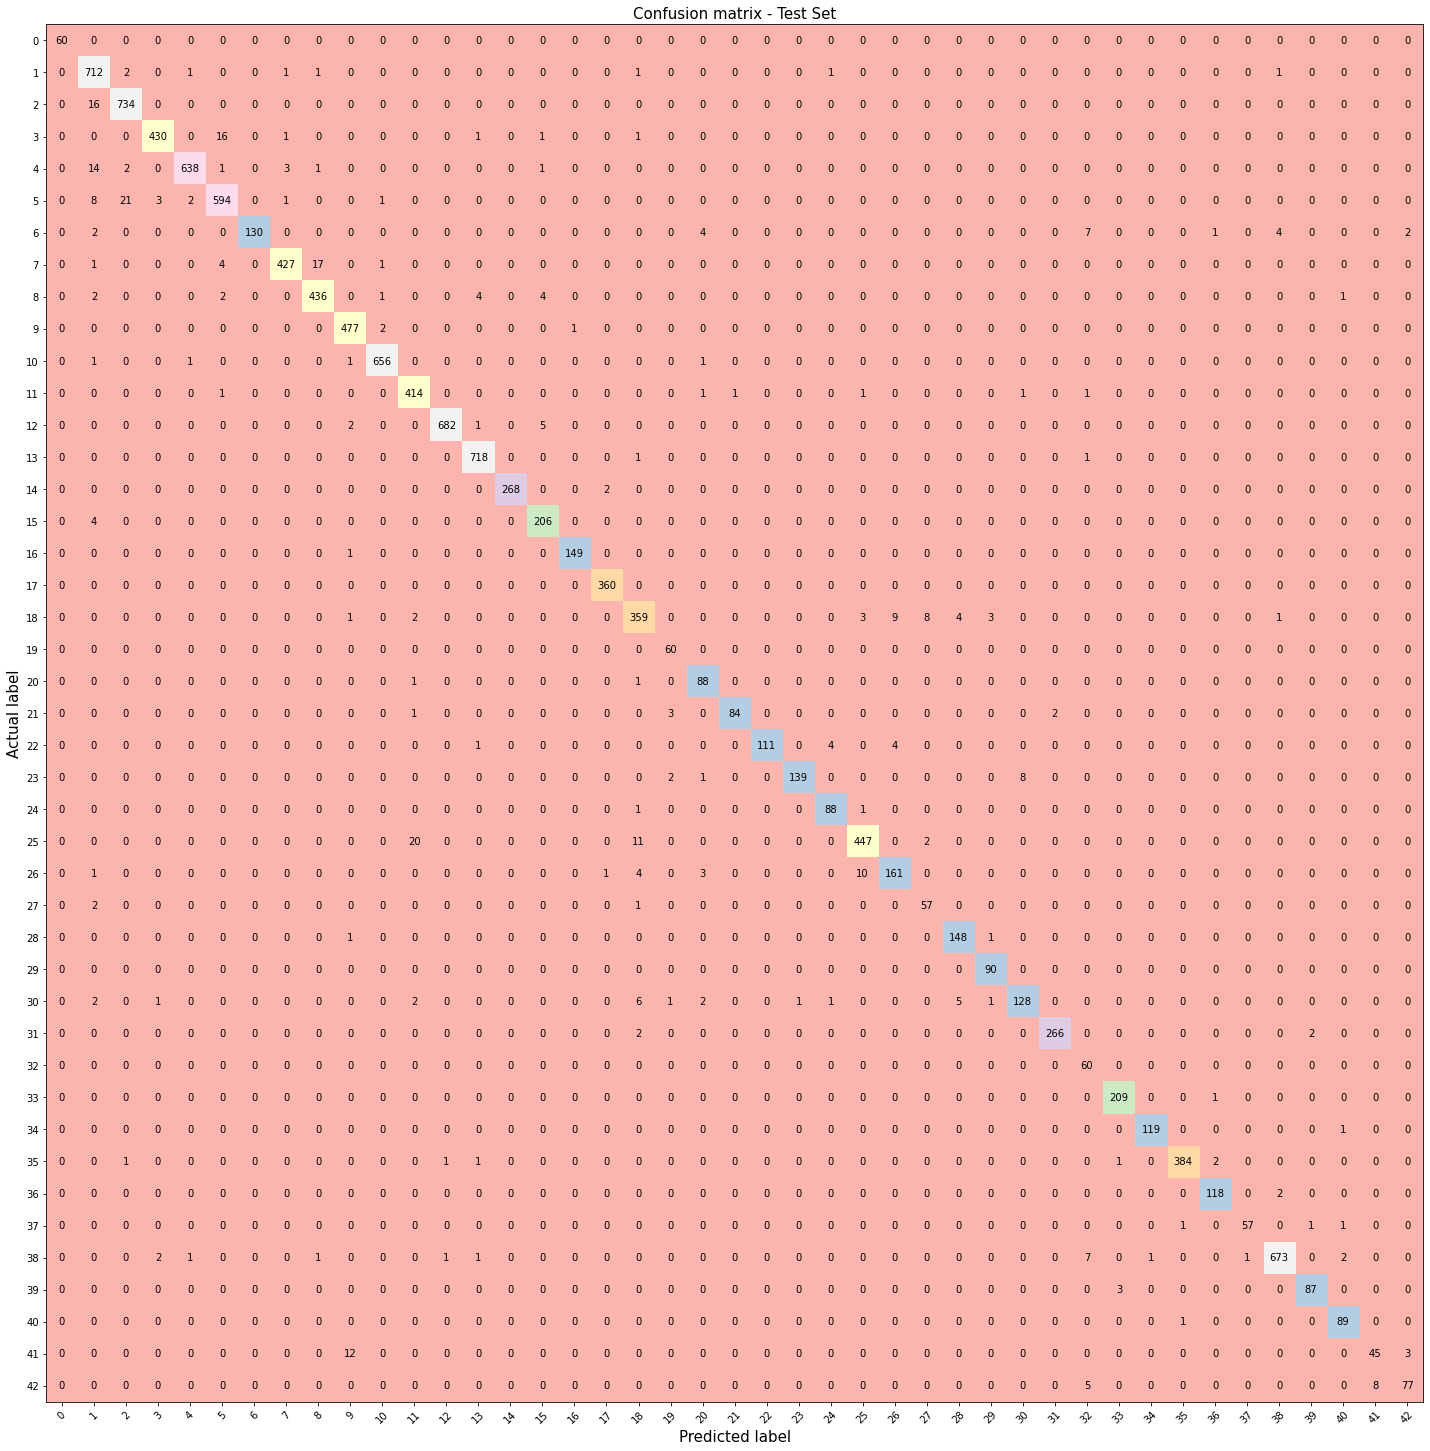

In [52]:
cnf_matrix_test = confusion_matrix_plot(y_test, classes_x)

In [53]:
index, cols = misclassified_img(cnf_matrix_test, X_test, y_test)
print(index, cols, len(index))

[2, 4, 5, 3, 7, 41, 25, 25] [1, 1, 2, 5, 8, 9, 11, 18] 8


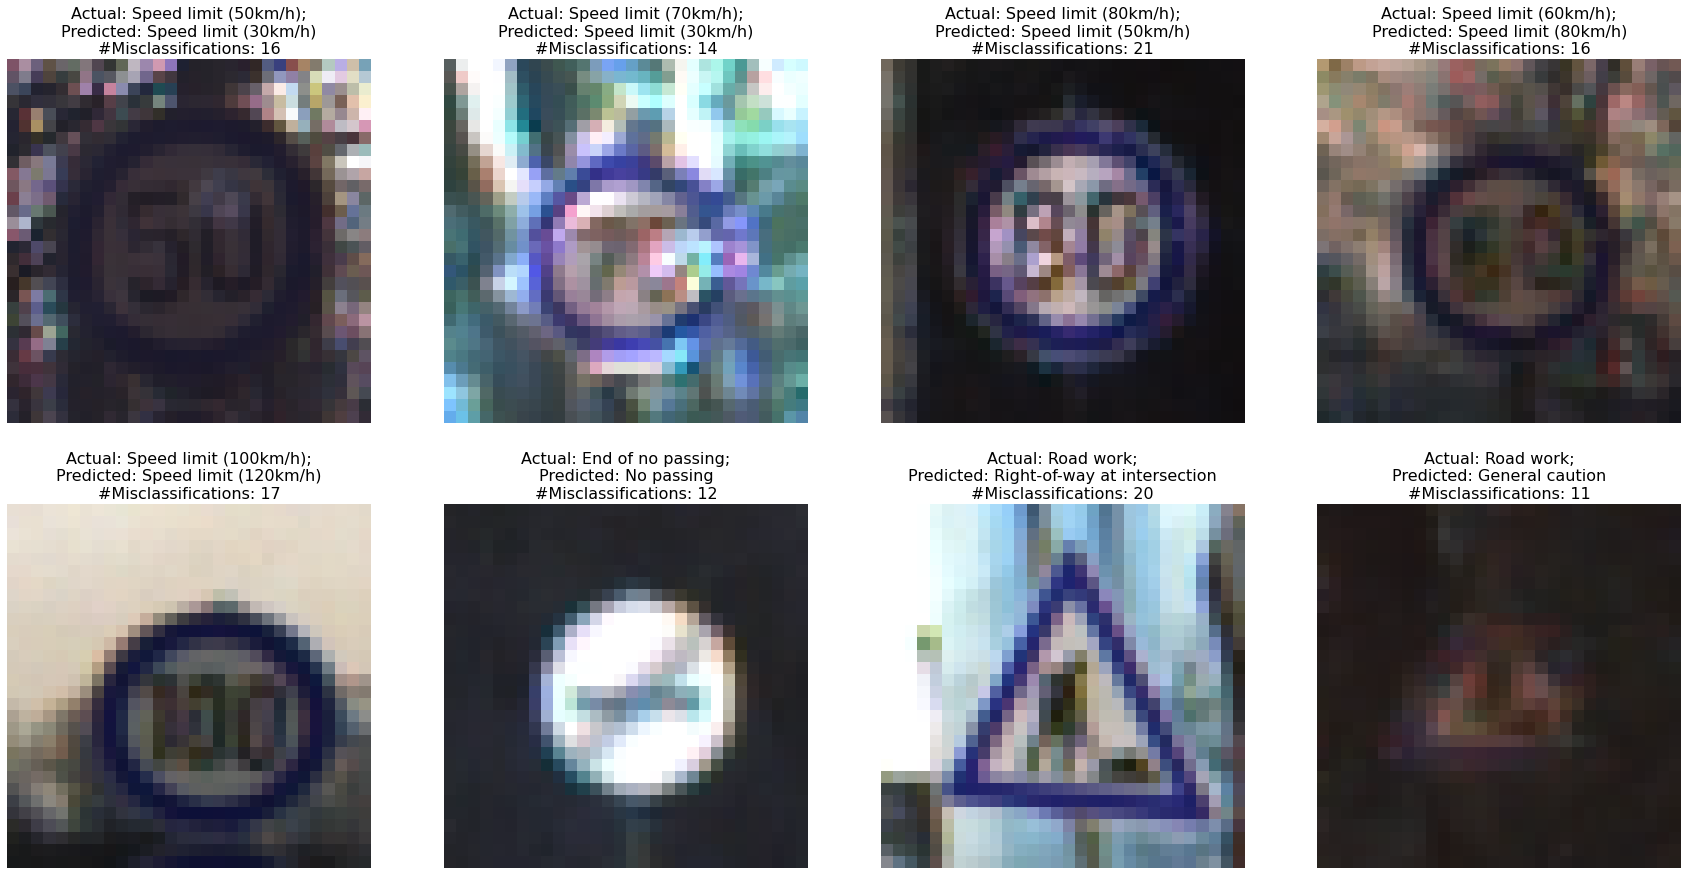

In [54]:
plot_misclassified_img(index, cols, X_test, y_test, 2, 4)

## Convert images to grayscale and run the CNN with 2 layers

In [4]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def pre_process(img):
    img = np.array(img)
    return grayscale(img).reshape([30,30,1])

def equalize(img):
    return cv2.equalizeHist(img.astype(np.uint8))

def exp_equalize(img):
    return exposure.equalize_hist(img.astype(np.uint8))


def plot_hist(img):
    plt.hist(img.flatten()*255, bins = 256)
    plt.show()
    return

In [103]:
data_preprocessed = np.array(list(map(pre_process, Cells)))
print(data_preprocessed.shape)

X_test_preprocessed = np.array(list(map(pre_process, X_test)))
print(X_test_preprocessed.shape)

(39209, 30, 30, 1)
(12630, 30, 30, 1)


In [104]:
#Splitting the images into train and validation sets
(X_train,X_val)=data_preprocessed[(int)(0.2*len(data_preprocessed)):],data_preprocessed[:(int)(0.2*len(data_preprocessed))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
# (y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

# #Using one hote encoding for the train and validation labels
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train, 43)
# y_val = to_categorical(y_val, 43)

In [105]:
X_train.shape,y_train.shape, X_val.shape,y_val.shape, X_test.shape,y_test.shape

((31368, 30, 30, 1),
 (31368, 43),
 (7841, 30, 30, 1),
 (7841, 43),
 (12630, 30, 30, 3),
 (12630,))

In [107]:
model_3_1 = Sequential()
model_3_1.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model_3_1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_3_1.add(MaxPool2D(pool_size=(2, 2)))
model_3_1.add(Dropout(rate=0.25))
model_3_1.add(Flatten())
model_3_1.add(Dense(256, activation='relu'))
model_3_1.add(Dropout(rate=0.5))
model_3_1.add(Dense(43, activation='softmax'))

model_3_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

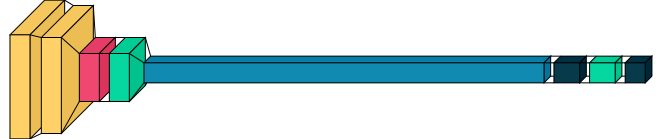

In [201]:
#change the model number to the the best performing one
visualkeras.layered_view(model_3_1)

In [108]:
history_3_1 = model_fitting(model_3_1, X_train, y_train, X_val, y_val)

Epoch 1/15
981/981 [==============================] - 69s 70ms/step - loss: 1.0500 - accuracy: 0.7113 - val_loss: 0.1625 - val_accuracy: 0.9611
Epoch 2/15
981/981 [==============================] - 74s 75ms/step - loss: 0.2585 - accuracy: 0.9230 - val_loss: 0.0805 - val_accuracy: 0.9795
Epoch 3/15
981/981 [==============================] - 69s 70ms/step - loss: 0.1620 - accuracy: 0.9512 - val_loss: 0.0523 - val_accuracy: 0.9885
Epoch 4/15
981/981 [==============================] - 75s 76ms/step - loss: 0.1206 - accuracy: 0.9631 - val_loss: 0.0444 - val_accuracy: 0.9892
Epoch 5/15
981/981 [==============================] - 70s 71ms/step - loss: 0.0913 - accuracy: 0.9706 - val_loss: 0.0342 - val_accuracy: 0.9911
Epoch 6/15
981/981 [==============================] - 70s 71ms/step - loss: 0.0764 - accuracy: 0.9757 - val_loss: 0.0346 - val_accuracy: 0.9922
Epoch 7/15
981/981 [==============================] - 70s 72ms/step - loss: 0.0651 - accuracy: 0.9790 - val_loss: 0.0313 - val_accuracy:

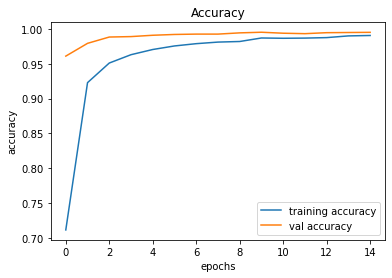

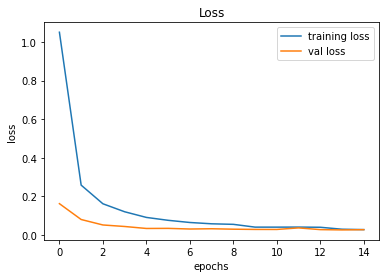

In [109]:
plot_accuracy(history_3_1)
plot_validation(history_3_1)

In [118]:
classes_x = predict_class(model_3_1, X_test_preprocessed)
model_3_1_accuracy = accuracy(y_test, classes_x)
print(model_3_1_accuracy)

0.9673000791765637


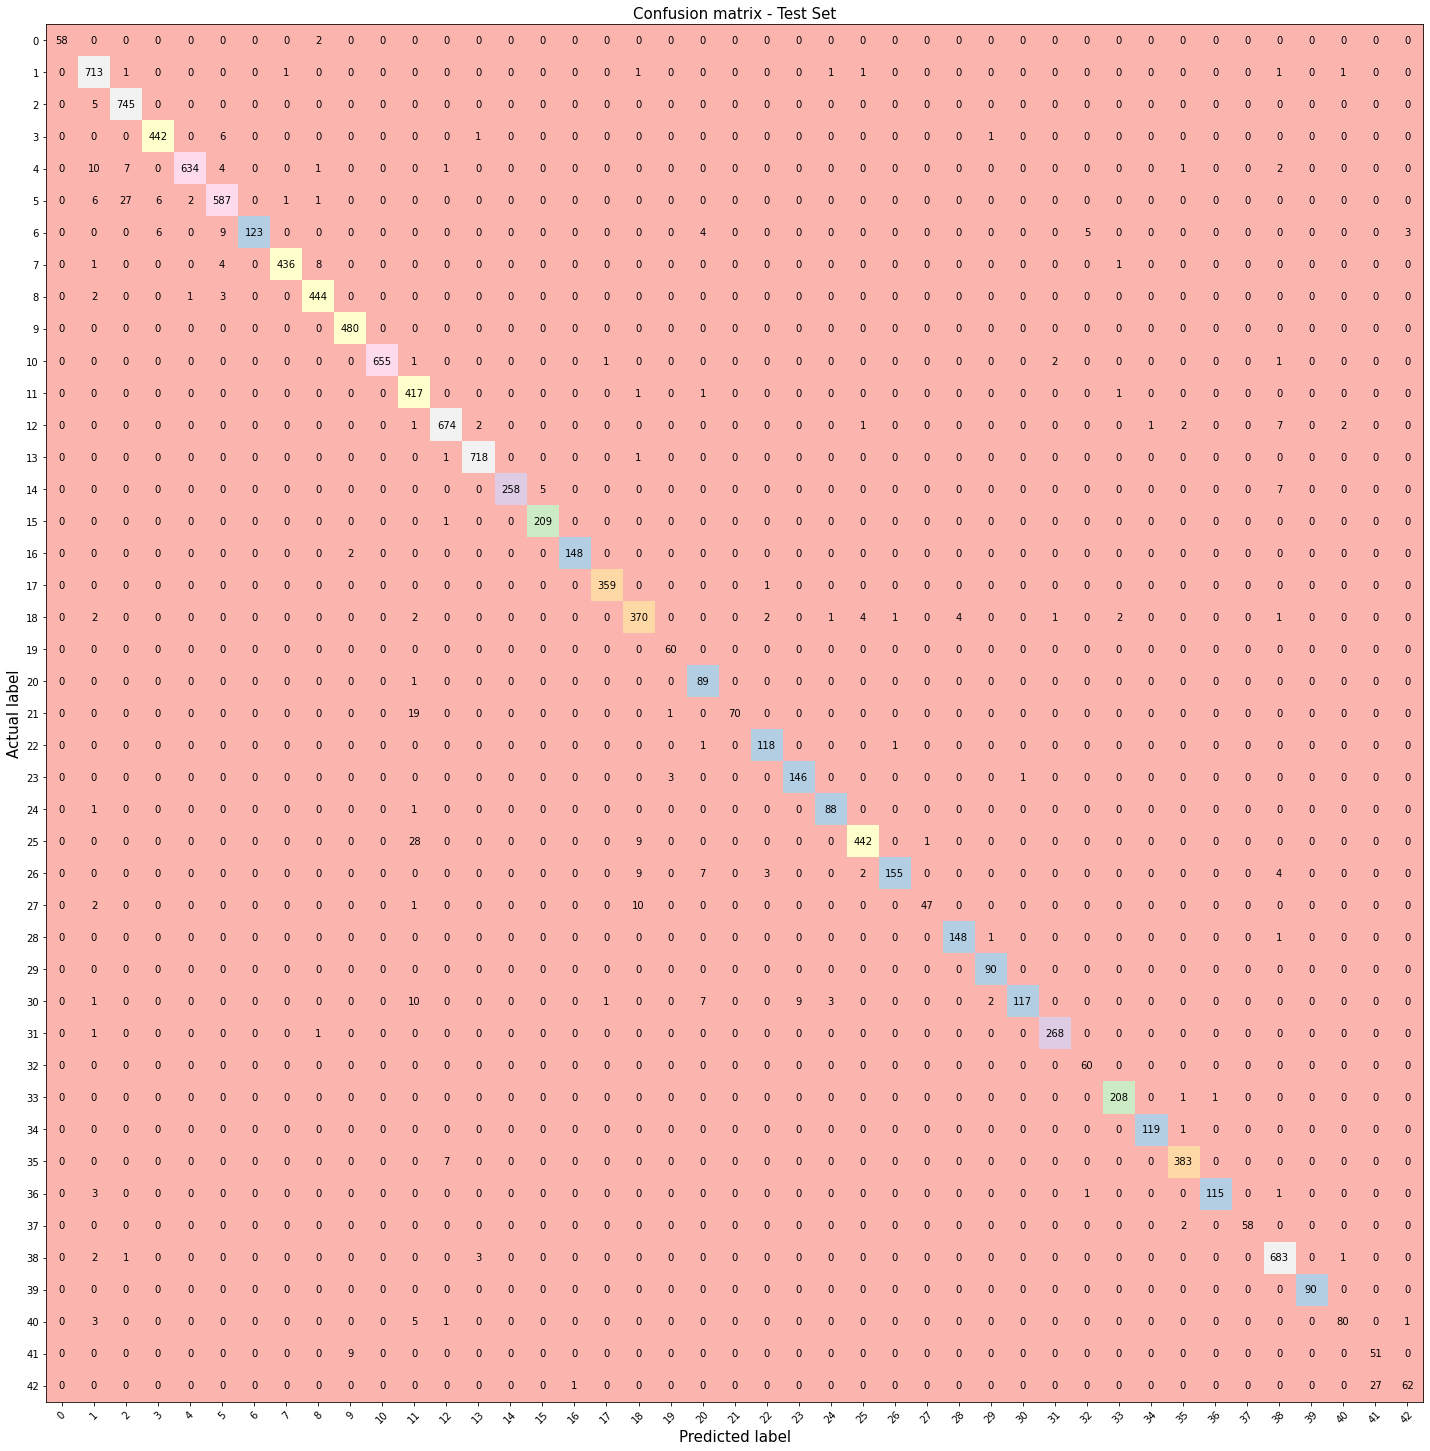

In [119]:
cnf_matrix_test = confusion_matrix_plot(y_test, classes_x)

In [120]:
index, cols = misclassified_img(cnf_matrix_test, X_test_preprocessed, y_test)
print(index, cols, len(index))

[5, 21, 25, 42] [2, 11, 11, 41] 4


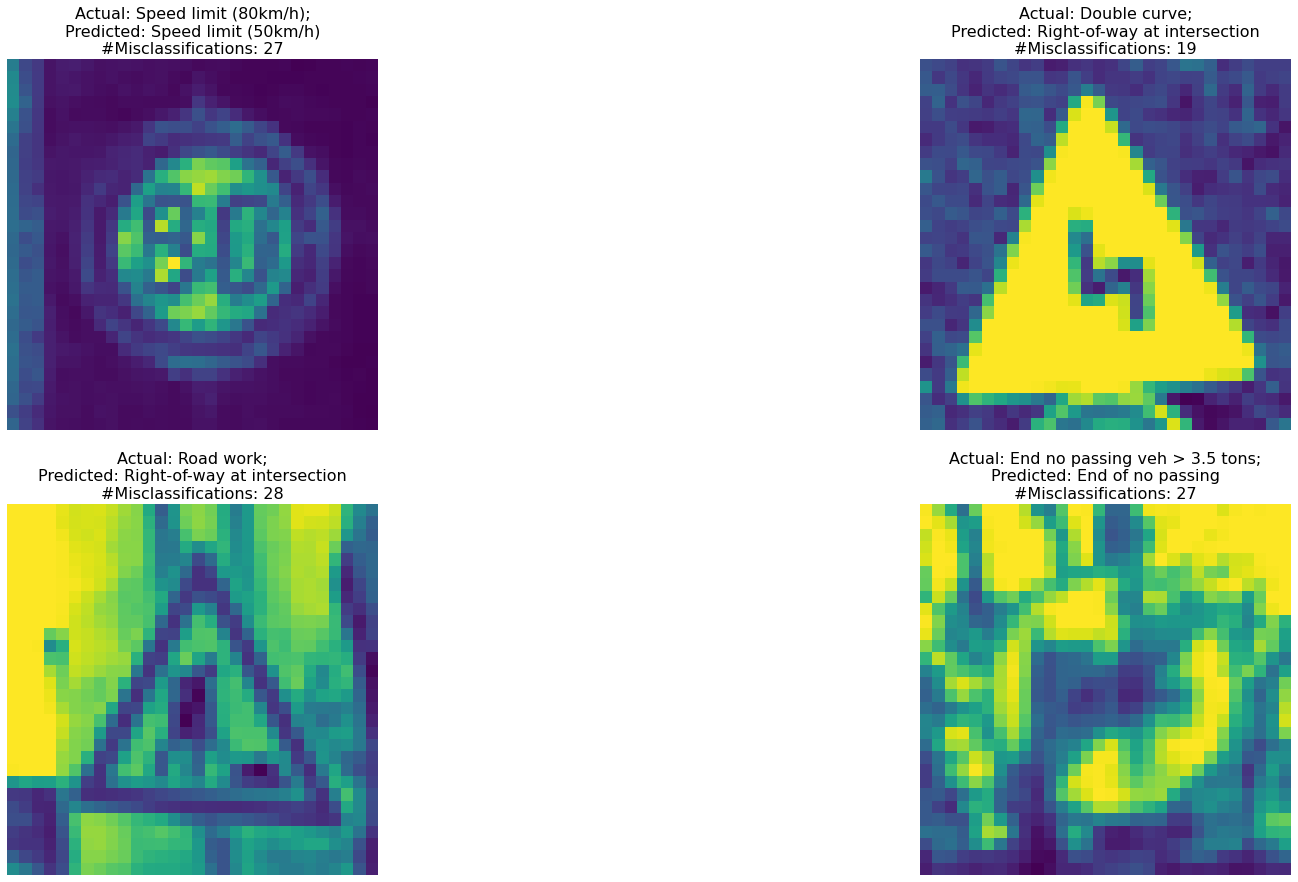

In [122]:
plot_misclassified_img(index, cols, X_test_preprocessed, y_test, 2, 2)

<AxesSubplot:title={'center':'Error by Class on Test Set'}>

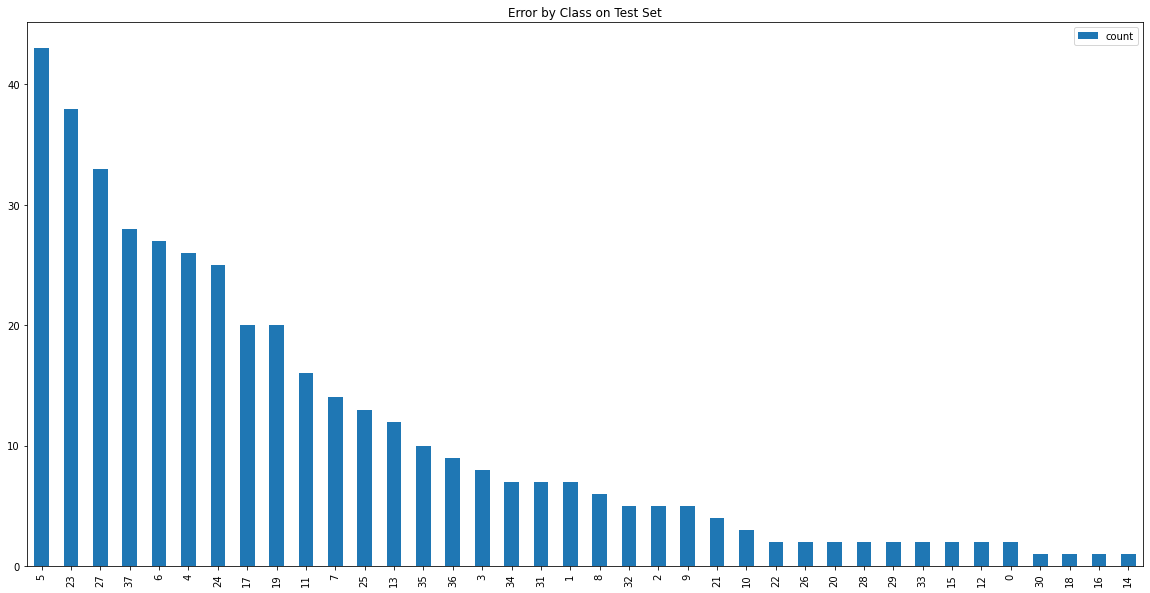

In [200]:
y_test[y_test!=classes_x]
unique_elements, counts_elements = np.unique(y_test[y_test!=classes_x], return_counts=True)
df_sorted = pd.DataFrame(counts_elements, index=[unique_elements],columns=['count']).reset_index(drop=True).sort_values(by=['count'],ascending=False)
df_sorted.plot(kind='bar',figsize=(20,10),title='Error by Class on Test Set')

## Compare accuracy of all models

In [123]:
accuracy_df = pd.DataFrame([model_2_accuracy, model_1_accuracy, model_3_accuracy, model_3_1_accuracy], index=['4_layers','3_layers','2_layers','2_layers_grayscale_data'], columns=['Accuracy'])
accuracy_df

,Accuracy
4_layers,0.967775
3_layers,0.956928
2_layers,0.968725
2_layers_grayscale_data,0.967300


## Comparing learning parameters for model with colored images and grayscaled images

### Colored images - 4864 parameters learned

In [135]:
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 26, 26, 64)        4864      
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_8 (Flatten)         (None, 9216)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               2359552   
                                                      

### Grayscaled images - 1664 parameters learned

In [129]:
model_3_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 26, 26, 64)        1664      
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2359552   
                                                      

## Interpolation

### Upsized image after INTER_CUBIC interpolation 

(30, 29)


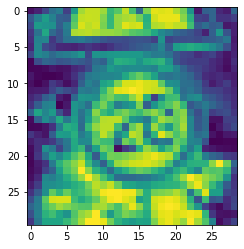

(60, 60)


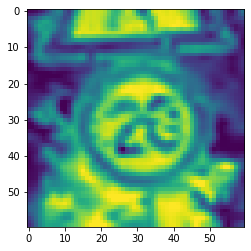

(60, 60)


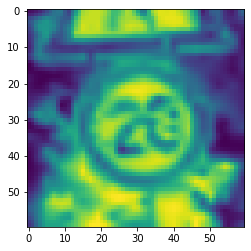

In [86]:
def pre_process_try(img):
    img = np.array(img)
    return equalize(grayscale(img))#.reshape([30,30,1])

# Upsampling 
path = "../Project/archive_new/Train/0/" # SMALL
Class=os.listdir(path)
# a = Class
# for id, a in enumerate(Class):
#     print(id, a)
# path = "../Project/archive_new/Train/1/00000_00005_00026.jpg" # MED
# path = "../Project/archive_new/Train/1/00000_00005_00029.jpg" # BIG
image = cv2.imread(path+Class[30])

image_from_array = Image.fromarray(image, 'RGB')
image_from_array = pre_process_try(image_from_array)
print(image_from_array.shape)
plt.imshow(image_from_array); plt.show()

img = cv2.resize(image_from_array, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
print(img.shape)
plt.imshow(img); plt.show()

img = cv2.resize(image_from_array, dsize=(60, 60))
print(img.shape)
plt.imshow(img)

### Downsized image after INTER_AREA interpolation

(64, 63)


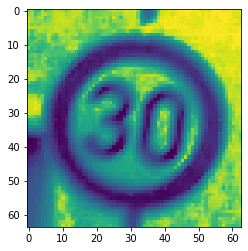

(30, 30)


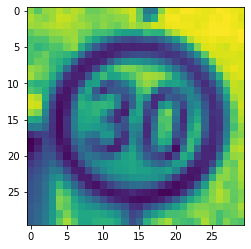

(30, 30)


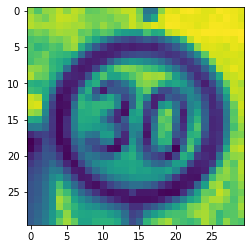

In [69]:
def pre_process_try(img):
    img = np.array(img)
    return equalize(grayscale(img))#.reshape([30,30,1])

# Downsampling 
path = "../Project/archive_new/Train/1/" # SMOLL
Class=os.listdir(path)
# a = Class
# for id, a in enumerate(Class):
#     print(id, a)
# path = "../Project/archive_new/Train/1/00000_00005_00026.jpg" # MED
# path = "../Project/archive_new/Train/1/00000_00005_00029.jpg" # BIG
image = cv2.imread(path+Class[149])

image_from_array = Image.fromarray(image, 'RGB')
image_from_array = pre_process_try(image_from_array)
print(image_from_array.shape)
plt.imshow(image_from_array); plt.show()

img = cv2.resize(image_from_array, dsize=(30, 30), interpolation=cv2.INTER_AREA)
print(img.shape)
plt.imshow(img); plt.show()

img = cv2.resize(image_from_array, dsize=(30, 30))
print(img.shape)
plt.imshow(img)

## Using Inter-cubic interpolation instead of inter-linear

In [43]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height * width * channels

for i in range(classes) :
    path = "../Project/archive_new/Train/{0}/".format(i)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            image_from_array = pre_process_try(image_from_array)
            size_image = cv2.resize(image_from_array, dsize=(height, width), interpolation=cv2.INTER_CUBIC)
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [44]:
#Splitting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#Using one hote encoding for the train and validation labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [45]:
#Predicting with the test data
height = 30
width = 30
y_test=pd.read_csv("../Project/archive_new/Test.csv")
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]

for f in labels:
    image=cv2.imread('../Project/archive_new/Test/'+f.replace('Test/', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    image_from_array = pre_process_try(image_from_array)
    size_image = cv2.resize(image_from_array, dsize=(height, width), interpolation=cv2.INTER_CUBIC)
    data.append(np.array(size_image))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model_3_2 = Sequential()
model_3_2.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model_3_2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_3_2.add(MaxPool2D(pool_size=(2, 2)))
model_3_2.add(Dropout(rate=0.25))
model_3_2.add(Flatten())
model_3_2.add(Dense(256, activation='relu'))
model_3_2.add(Dropout(rate=0.5))
model_3_2.add(Dense(43, activation='softmax'))

model_3_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
X_train.shape,y_train.shape, X_val.shape,y_val.shape, X_test.shape,y_test.shape

((31368, 30, 30, 1),
 (31368, 43),
 (7841, 30, 30, 1),
 (7841, 43),
 (12630, 30, 30, 1),
 (12630,))

In [51]:
X_train = X_train.reshape((31368,30,30,1))
X_val = X_val.reshape((7841,30,30,1))
X_test = X_test.reshape((12630,30,30,1))

In [54]:
history_3_2 = model_fitting(model_3_2, X_train, y_train, X_val, y_val)

Epoch 1/15
981/981 [==============================] - 84s 85ms/step - loss: 0.8840 - accuracy: 0.7481 - val_loss: 0.1532 - val_accuracy: 0.9563
Epoch 2/15
981/981 [==============================] - 83s 84ms/step - loss: 0.2254 - accuracy: 0.9308 - val_loss: 0.0767 - val_accuracy: 0.9781
Epoch 3/15
981/981 [==============================] - 83s 84ms/step - loss: 0.1390 - accuracy: 0.9557 - val_loss: 0.0524 - val_accuracy: 0.9862
Epoch 4/15
981/981 [==============================] - 69s 71ms/step - loss: 0.1017 - accuracy: 0.9676 - val_loss: 0.0431 - val_accuracy: 0.9880
Epoch 5/15
981/981 [==============================] - 62s 64ms/step - loss: 0.0750 - accuracy: 0.9762 - val_loss: 0.0541 - val_accuracy: 0.9852
Epoch 6/15
981/981 [==============================] - 61s 62ms/step - loss: 0.0697 - accuracy: 0.9781 - val_loss: 0.0466 - val_accuracy: 0.9858
Epoch 7/15
981/981 [==============================] - 59s 61ms/step - loss: 0.0536 - accuracy: 0.9821 - val_loss: 0.0422 - val_accuracy:

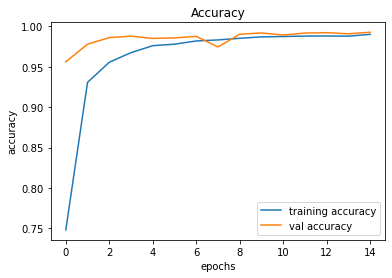

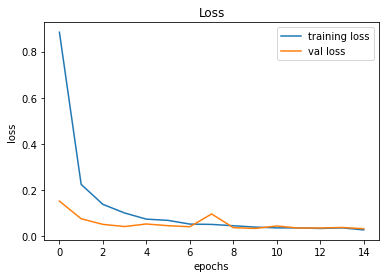

In [55]:
plot_accuracy(history_3_2)
plot_validation(history_3_2)

In [56]:
classes_x = predict_class(model_3_2, X_test)
model_3_2_accuracy = accuracy(y_test, classes_x)
print(model_3_2_accuracy)

0.9646080760095012


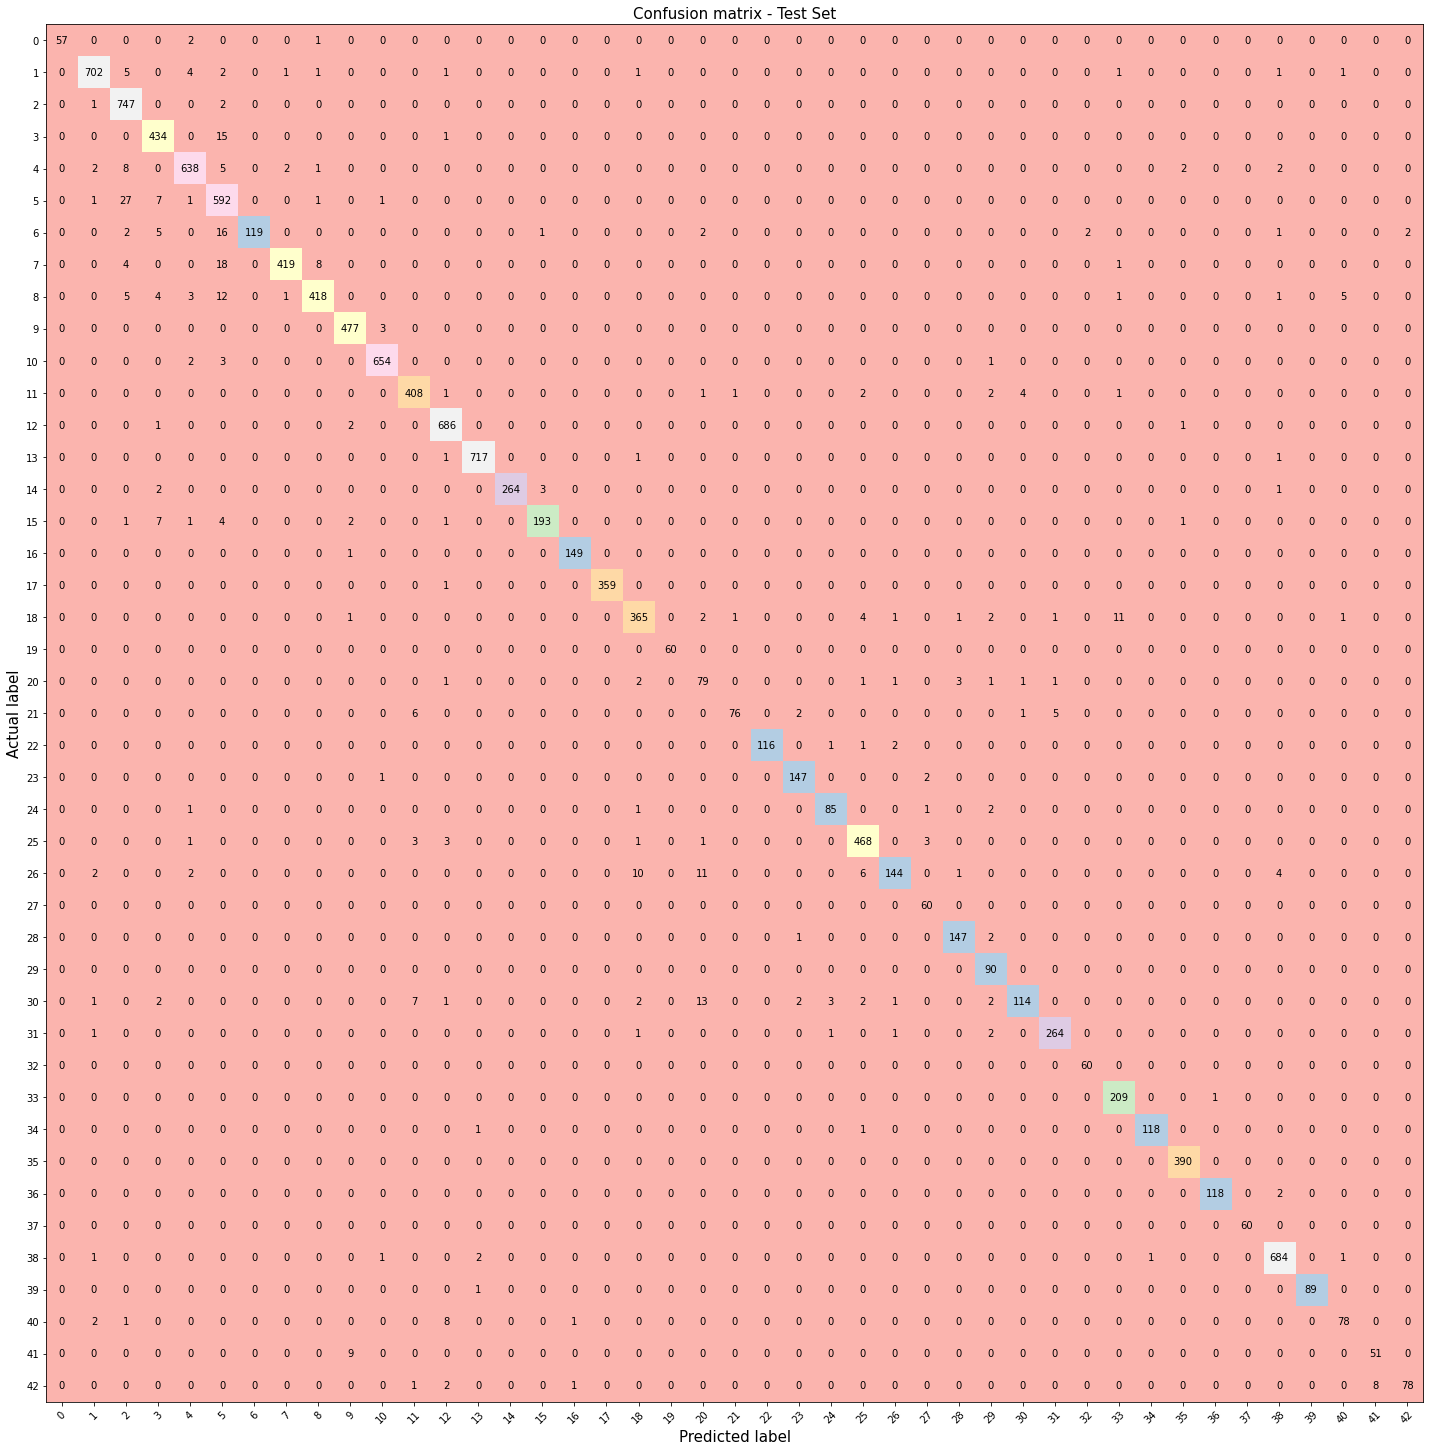

In [57]:
cnf_matrix_test = confusion_matrix_plot(y_test, classes_x)

In [58]:
index, cols = misclassified_img(cnf_matrix_test, X_test, y_test)
print(index, cols, len(index))

[5, 3, 6, 7, 8, 26, 30, 18] [2, 5, 5, 5, 5, 20, 20, 33] 8


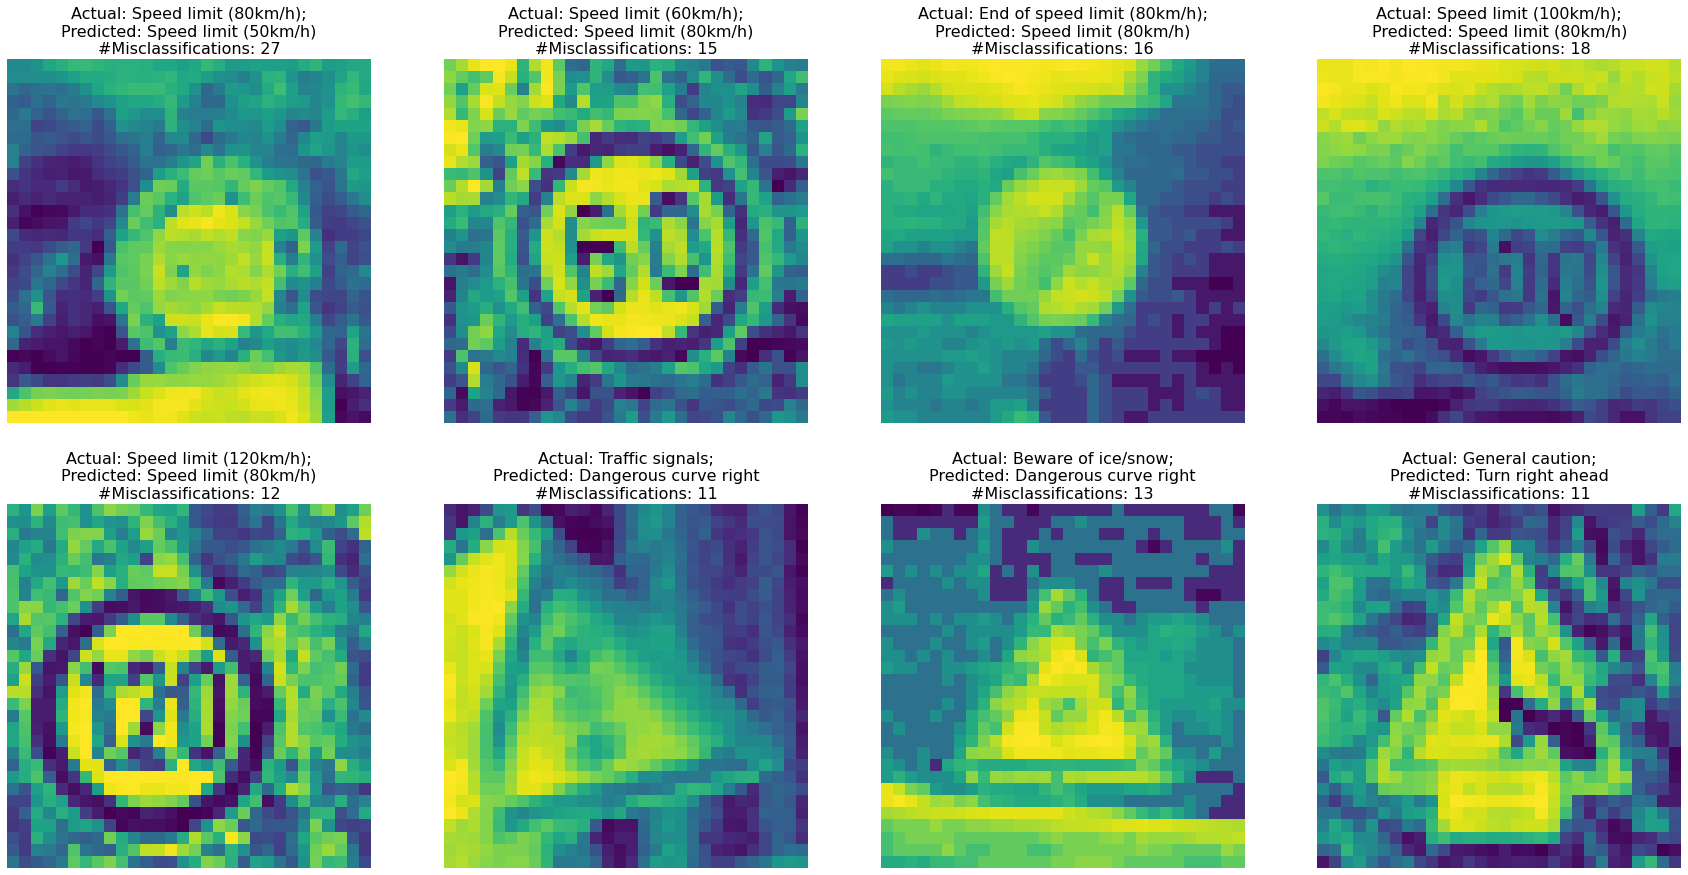

In [60]:
plot_misclassified_img(index, cols, X_test, y_test, 2, 4)

## Using Inter-area interpolation instead of inter-linear as we are mostly downsizing images

In [70]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height * width * channels

for i in range(classes) :
    path = "../Project/archive_new/Train/{0}/".format(i)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image_from_array = Image.fromarray(image, 'RGB')
            image_from_array = pre_process_try(image_from_array)
            size_image = cv2.resize(image_from_array, dsize=(height, width), interpolation=cv2.INTER_AREA)
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [71]:
#Splitting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#Using one hote encoding for the train and validation labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [72]:
#Predicting with the test data
height = 30
width = 30
y_test=pd.read_csv("../Project/archive_new/Test.csv")
labels=y_test['Path'].to_numpy()
y_test=y_test['ClassId'].values

data=[]

for f in labels:
    image=cv2.imread('../Project/archive_new/Test/'+f.replace('Test/', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    image_from_array = pre_process_try(image_from_array)
    size_image = cv2.resize(image_from_array, dsize=(height, width), interpolation=cv2.INTER_AREA)
    data.append(np.array(size_image))

X_test=np.array(data)
X_test = X_test.astype('float32')/255 

In [74]:
X_train = X_train.reshape((31368,30,30,1))
X_val = X_val.reshape((7841,30,30,1))
X_test = X_test.reshape((12630,30,30,1))

In [75]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model_3_3 = Sequential()
model_3_3.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model_3_3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_3_3.add(MaxPool2D(pool_size=(2, 2)))
model_3_3.add(Dropout(rate=0.25))
model_3_3.add(Flatten())
model_3_3.add(Dense(256, activation='relu'))
model_3_3.add(Dropout(rate=0.5))
model_3_3.add(Dense(43, activation='softmax'))

model_3_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
history_3_3 = model_fitting(model_3_3, X_train, y_train, X_val, y_val)

Epoch 1/15
981/981 [==============================] - 64s 65ms/step - loss: 1.0122 - accuracy: 0.7140 - val_loss: 0.1893 - val_accuracy: 0.9499
Epoch 2/15
981/981 [==============================] - 63s 64ms/step - loss: 0.2793 - accuracy: 0.9118 - val_loss: 0.1094 - val_accuracy: 0.9694
Epoch 3/15
981/981 [==============================] - 61s 62ms/step - loss: 0.1782 - accuracy: 0.9438 - val_loss: 0.0832 - val_accuracy: 0.9768
Epoch 4/15
981/981 [==============================] - 60s 62ms/step - loss: 0.1311 - accuracy: 0.9571 - val_loss: 0.0528 - val_accuracy: 0.9851
Epoch 5/15
981/981 [==============================] - 61s 62ms/step - loss: 0.1094 - accuracy: 0.9652 - val_loss: 0.0526 - val_accuracy: 0.9841
Epoch 6/15
981/981 [==============================] - 60s 61ms/step - loss: 0.0945 - accuracy: 0.9687 - val_loss: 0.0444 - val_accuracy: 0.9880
Epoch 7/15
981/981 [==============================] - 66s 68ms/step - loss: 0.0803 - accuracy: 0.9727 - val_loss: 0.0357 - val_accuracy:

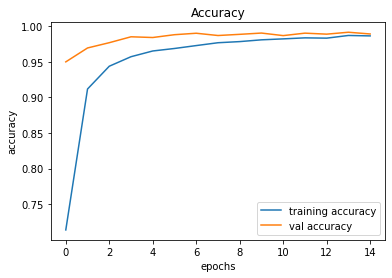

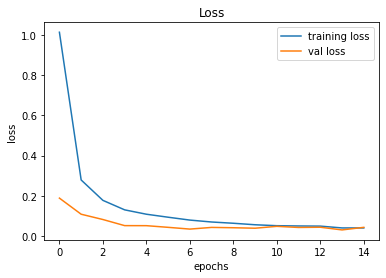

In [77]:
plot_accuracy(history_3_3)
plot_validation(history_3_3)

In [78]:
classes_x = predict_class(model_3_3, X_test)
model_3_3_accuracy = accuracy(y_test, classes_x)
print(model_3_3_accuracy)

0.9592240696753761


## Comparing Accuracies of processed images with original model

In [93]:
accuracy_df = pd.DataFrame([model_3_accuracy, model_3_1_accuracy, model_3_2_accuracy, model_3_3_accuracy], index=['RGB','Grayscale INTER_LINEAR','Grayscale INTER_CUBIC','Grayscale INTER_AREA'], columns=['Accuracy'])
accuracy_df = accuracy_df.rename_axis('2-layered CNN')
accuracy_df

,Accuracy
2-layered CNN,
RGB,0.968963
Grayscale INTER_LINEAR,0.967300
Grayscale INTER_CUBIC,0.964608
Grayscale INTER_AREA,0.959224


# END-OF-CODE